In [ ]:


import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1) Load + flatten JSON
# -------------------------
json_path = Path("summary_results_enriched.json")
assert json_path.exists(), f"Missing {json_path.resolve()}"

with json_path.open("r", encoding="utf-8") as f:
    data = json.load(f)

# data should be a list[dict]
df = pd.json_normalize(data, sep=".")
df.head()


,id,dataset,machines,cores,quantum_ms,total_time_to_run.sim_makespan_ms,total_time_to_run.estimated_wall_seconds,fairness.jobs,fairness.max_arrival_time_ms,fairness.sim_makespan_ms,...,fairness.slowdown_p50,fairness.slowdown_p95,fairness.slowdown_p99,fairness.slowdown_max,fairness.slowdown_cv,fairness.slowdown_gini,fairness.slowdown_jain,sources.jobs_csv,sources.run_csv,sources.directory
0,0048287ba9,small,2,2,20,14738000.0,7.369,1000,0.0,14738000.0,...,212100.000000,1.253383e+06,2.246390e+06,2.786000e+06,1.141873,0.519958,0.434052,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...
1,009e310875,large,16,2,10,241764000.0,120.882,1000,0.0,241764000.0,...,371786.028331,4.257559e+05,5.274504e+05,6.878571e+05,0.150331,0.080818,0.977900,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...
2,04f543ac28,large,8,2,500,67000000.0,3.350,1000,0.0,67000000.0,...,77358.537292,1.320227e+05,1.338658e+06,4.027500e+06,2.133339,0.468044,0.180143,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...
3,08a78e0c55,large,16,2,20,105174000.0,52.587,1000,0.0,105174000.0,...,160858.691735,1.779823e+05,2.363718e+05,3.745000e+05,0.151913,0.076563,0.977443,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...
4,135267c06e,medium,8,4,200,56440000.0,2.822,1000,0.0,56440000.0,...,250626.780627,2.501722e+06,4.785404e+06,8.166667e+06,1.737249,0.617745,0.248878,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...,C:\facultate\TaskSchedulerHW\round-robin\resul...


In [ ]:
# -------------------------
# 2) Basic cleanup + derived columns
# -------------------------

for col in ["id", "dataset", "machines", "cores", "quantum_ms"]:
    if col not in df.columns:
        df[col] = np.nan

# total slots (capacity)
df["total_slots"] = pd.to_numeric(df["machines"], errors="coerce") * pd.to_numeric(df["cores"], errors="coerce")

if "total_time_to_run.sim_makespan_ms" not in df.columns:
    df["total_time_to_run.sim_makespan_ms"] = np.nan

if "fairness.speedup" not in df.columns:
    df["fairness.speedup"] = np.nan

if "total_time_to_run.estimated_wall_seconds" not in df.columns:
    df["total_time_to_run.estimated_wall_seconds"] = np.nan

mask_missing_wall = df["total_time_to_run.estimated_wall_seconds"].isna()
df.loc[mask_missing_wall, "total_time_to_run.estimated_wall_seconds"] = (
    pd.to_numeric(df.loc[mask_missing_wall, "total_time_to_run.sim_makespan_ms"], errors="coerce")
    / pd.to_numeric(df.loc[mask_missing_wall, "fairness.speedup"], errors="coerce")
    / 1000.0
)

if df["fairness.speedup"].isna().all() and "speedup" in df.columns:
    df["fairness.speedup"] = pd.to_numeric(df["speedup"], errors="coerce")

# Ensure numeric
num_cols = [
    "quantum_ms",
    "total_slots",
    "total_time_to_run.sim_makespan_ms",
    "total_time_to_run.estimated_wall_seconds",
    "fairness.waiting_gini",
    "fairness.slowdown_gini",
    "fairness.slowdown_jain",
    "fairness.waiting_p95_ms",
    "fairness.waiting_p99_ms",
    "fairness.slowdown_p95",
    "fairness.slowdown_p99",
    "fairness.jobs",
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Throughput (jobs/sec)
if "fairness.jobs" in df.columns:
    df["throughput_jobs_per_s"] = df["fairness.jobs"] / df["total_time_to_run.estimated_wall_seconds"]

# Clean dataset labels
df["dataset"] = df["dataset"].astype(str).str.lower().str.strip()

# Drop rows without essentials
df = df.dropna(subset=["id", "dataset", "quantum_ms", "total_slots", "total_time_to_run.estimated_wall_seconds"])
df = df[df["total_time_to_run.estimated_wall_seconds"] > 0]

# Sort
df = df.sort_values(["dataset", "total_slots", "quantum_ms"]).reset_index(drop=True)
df[["id","dataset","machines","cores","total_slots","quantum_ms","total_time_to_run.estimated_wall_seconds"]].head()


,id,dataset,machines,cores,total_slots,quantum_ms,total_time_to_run.estimated_wall_seconds
0,8a41c5376b,large,2,2,4,10,140.321
1,4dc9196f9f,large,2,2,4,20,68.613
2,c46b7cdc07,large,2,2,4,50,26.576
3,f041e7f06f,large,2,2,4,100,13.091
4,6f29bdb41a,large,2,2,4,200,8.006


In [ ]:
# -------------------------
# 3) Helper utilities
# -------------------------
def _dataset_values(dframe: pd.DataFrame):
    return sorted([d for d in dframe["dataset"].dropna().unique() if d not in ("nan", "")])

def _plot_lines_by_group(
    dframe: pd.DataFrame,
    x: str,
    y: str,
    group: str,
    title: str,
    xlabel: str,
    ylabel: str,
    logx: bool = False,
    logy: bool = False,
):
    """
    One figure. Plots y vs x for each unique 'group' value (lines).
    Uses matplotlib default colors.
    """
    plt.figure()
    for g, sub in dframe.groupby(group):
        sub = sub.dropna(subset=[x, y]).sort_values(x)
        if len(sub) == 0:
            continue
        plt.plot(sub[x], sub[y], marker="o", label=str(g))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale("log")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(title=group, loc="best")
    plt.show()

def _plot_scatter(
    dframe: pd.DataFrame,
    x: str,
    y: str,
    label_col: str | None,
    title: str,
    xlabel: str,
    ylabel: str,
    logx: bool = False,
    logy: bool = False,
):
    plt.figure()
    sub = dframe.dropna(subset=[x, y]).copy()
    plt.scatter(sub[x], sub[y])
    if label_col is not None and label_col in sub.columns:
        pass
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale("log")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()


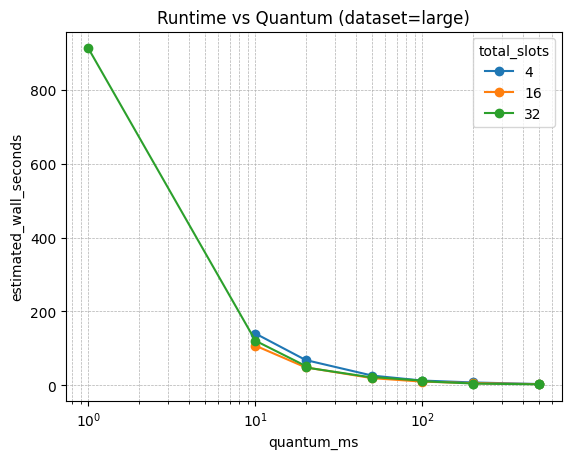

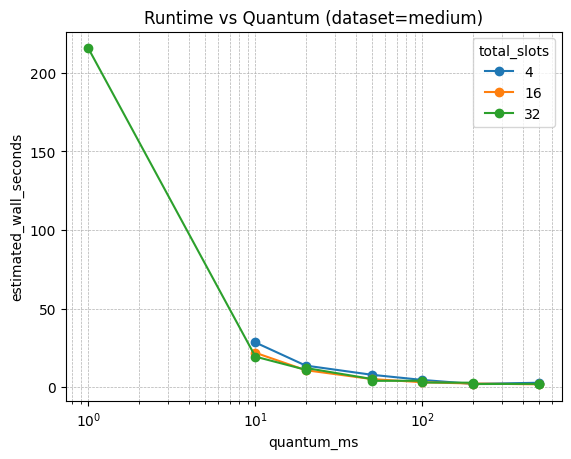

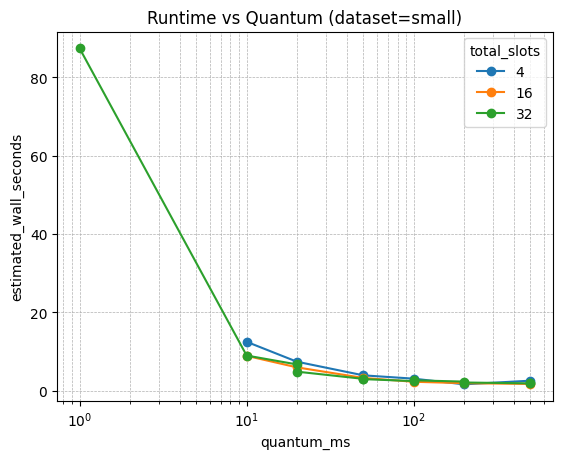

In [22]:
# -------------------------
# 4) A) Runtime vs quantum (per dataset)
#     x=quantum_ms (log), y=estimated_wall_seconds
#     line per total_slots
# -------------------------
for ds in _dataset_values(df):
    sub = df[df["dataset"] == ds].copy()
    _plot_lines_by_group(
        sub,
        x="quantum_ms",
        y="total_time_to_run.estimated_wall_seconds",
        group="total_slots",
        title=f"Runtime vs Quantum (dataset={ds})",
        xlabel="quantum_ms",
        ylabel="estimated_wall_seconds",
        logx=True,
        logy=False,
    )


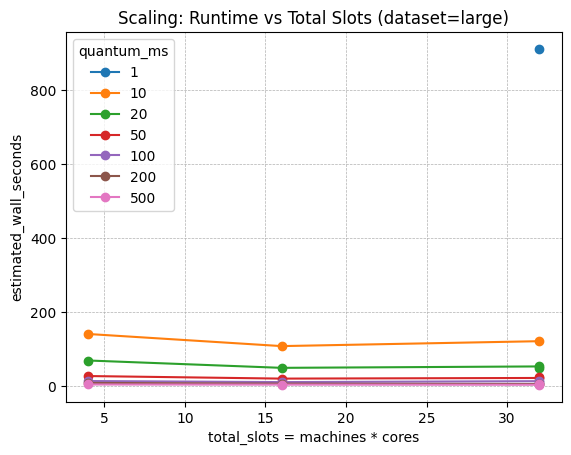

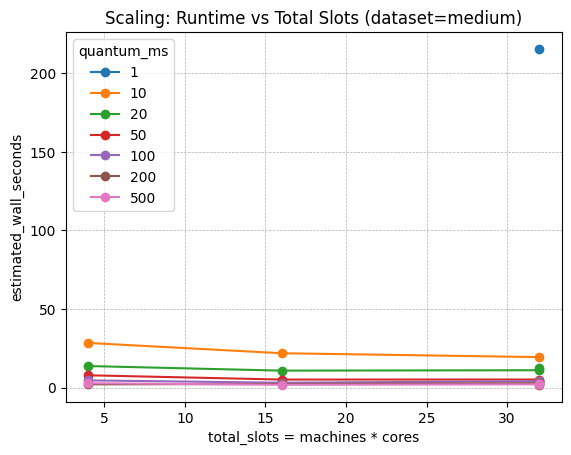

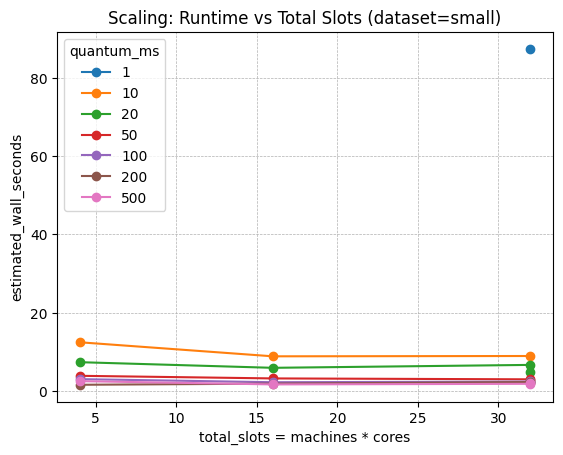

In [23]:
# -------------------------
# 5) B) Runtime vs total slots (scaling curve) per dataset
#     x=total_slots, y=estimated_wall_seconds
#     line per quantum_ms
# -------------------------
for ds in _dataset_values(df):
    sub = df[df["dataset"] == ds].copy()
    _plot_lines_by_group(
        sub,
        x="total_slots",
        y="total_time_to_run.estimated_wall_seconds",
        group="quantum_ms",
        title=f"Scaling: Runtime vs Total Slots (dataset={ds})",
        xlabel="total_slots = machines * cores",
        ylabel="estimated_wall_seconds",
        logx=False,
        logy=False,
    )


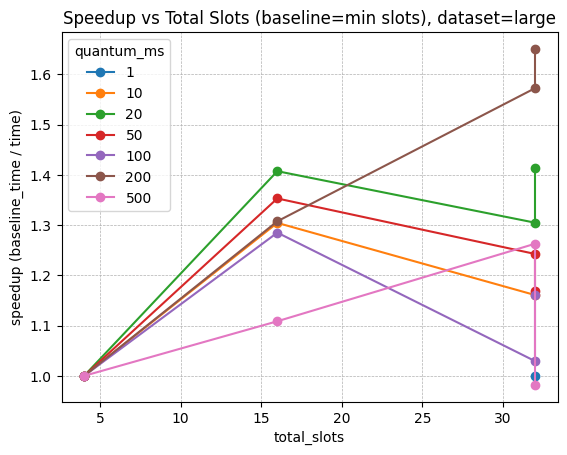

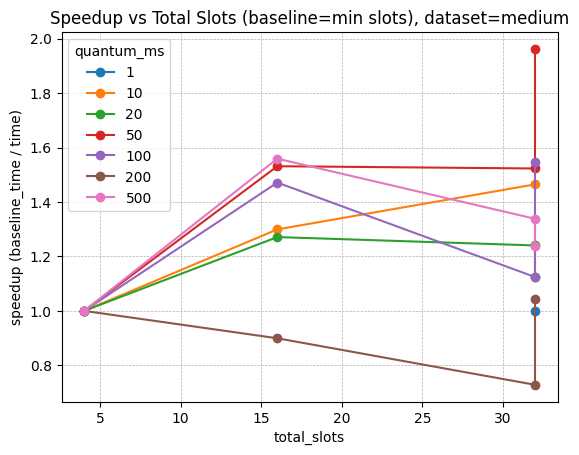

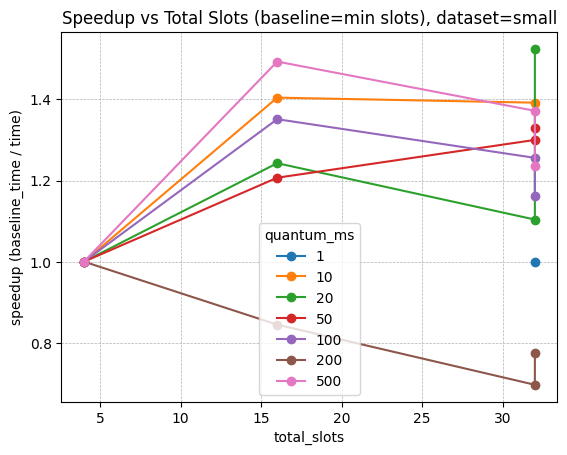

In [24]:
# -------------------------
# 6) C) Speedup relative to baseline (per dataset)
# Baseline: smallest total_slots within each (dataset, quantum_ms)
# speedup = baseline_time / time
# -------------------------
speed_df = df.copy()

# baseline time per (dataset, quantum)
baseline = (
    speed_df.sort_values("total_slots")
    .groupby(["dataset", "quantum_ms"], as_index=False)
    .first()[["dataset","quantum_ms","total_time_to_run.estimated_wall_seconds","total_slots"]]
    .rename(columns={
        "total_time_to_run.estimated_wall_seconds": "baseline_time_s",
        "total_slots": "baseline_slots",
    })
)

speed_df = speed_df.merge(baseline, on=["dataset","quantum_ms"], how="left")
speed_df["speedup_vs_baseline"] = speed_df["baseline_time_s"] / speed_df["total_time_to_run.estimated_wall_seconds"]

for ds in _dataset_values(speed_df):
    sub = speed_df[speed_df["dataset"] == ds].copy()
    _plot_lines_by_group(
        sub,
        x="total_slots",
        y="speedup_vs_baseline",
        group="quantum_ms",
        title=f"Speedup vs Total Slots (baseline=min slots), dataset={ds}",
        xlabel="total_slots",
        ylabel="speedup (baseline_time / time)",
        logx=False,
        logy=False,
    )


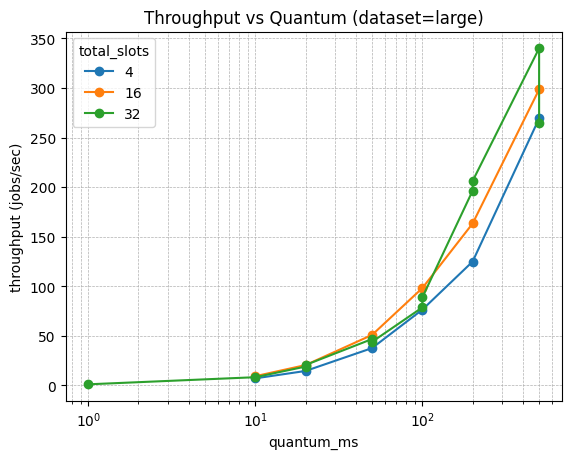

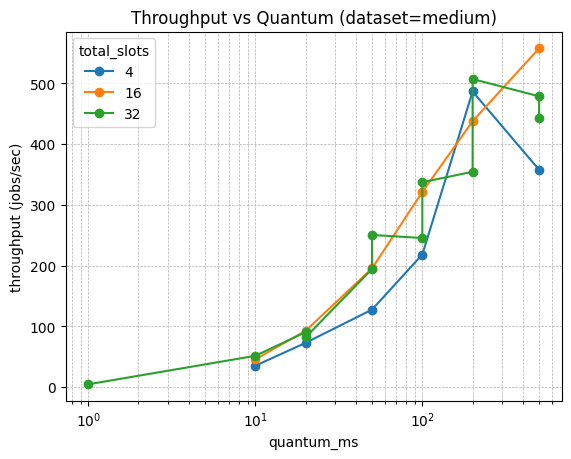

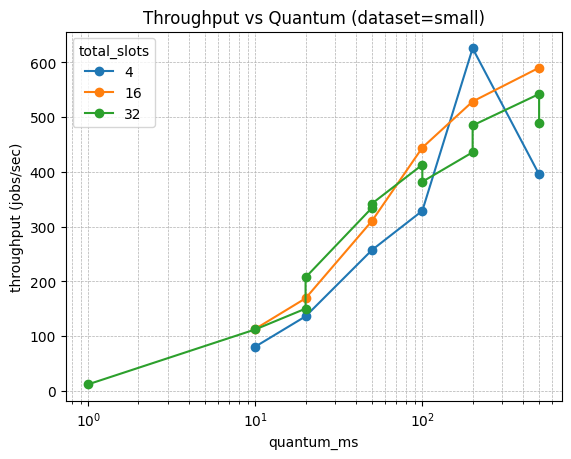

In [25]:
# -------------------------
# 7) D) Throughput (jobs/sec) vs quantum (per dataset)
# -------------------------
if "throughput_jobs_per_s" in df.columns and df["throughput_jobs_per_s"].notna().any():
    for ds in _dataset_values(df):
        sub = df[df["dataset"] == ds].copy()
        _plot_lines_by_group(
            sub,
            x="quantum_ms",
            y="throughput_jobs_per_s",
            group="total_slots",
            title=f"Throughput vs Quantum (dataset={ds})",
            xlabel="quantum_ms",
            ylabel="throughput (jobs/sec)",
            logx=True,
            logy=False,
        )
else:
    print("No throughput_jobs_per_s available (missing fairness.jobs or wall time).")


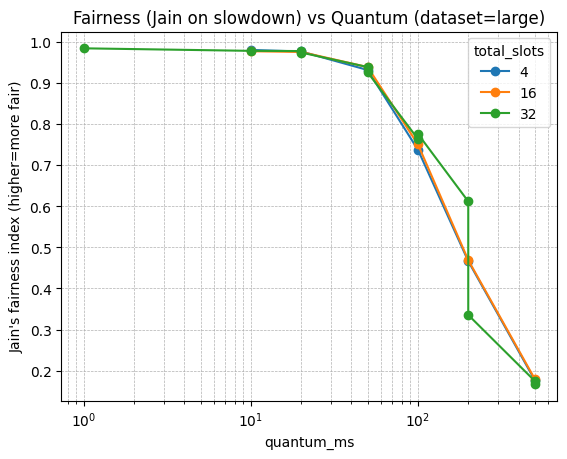

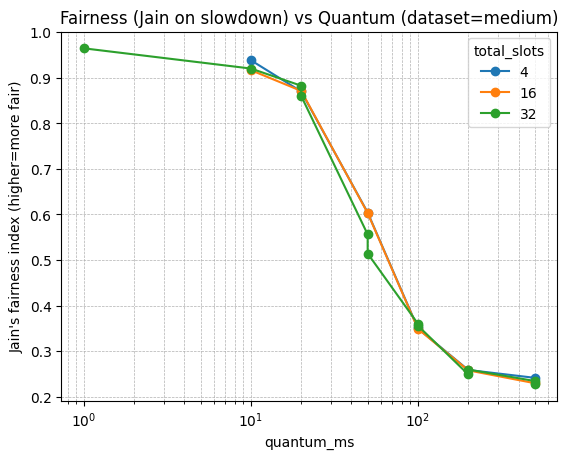

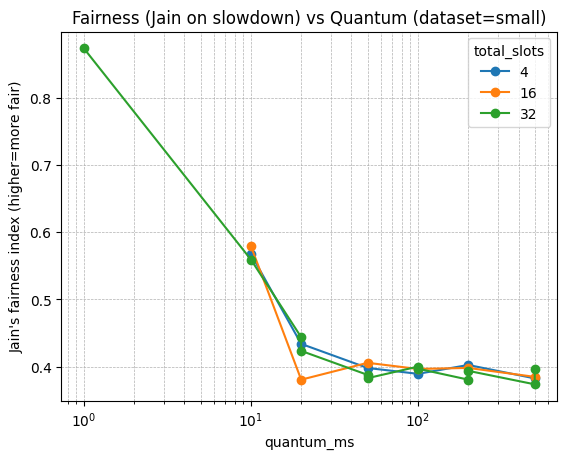

In [26]:
# -------------------------
# 8) E) Jain's fairness vs quantum (per dataset)
# -------------------------
if "fairness.slowdown_jain" in df.columns and df["fairness.slowdown_jain"].notna().any():
    for ds in _dataset_values(df):
        sub = df[df["dataset"] == ds].copy()
        _plot_lines_by_group(
            sub,
            x="quantum_ms",
            y="fairness.slowdown_jain",
            group="total_slots",
            title=f"Fairness (Jain on slowdown) vs Quantum (dataset={ds})",
            xlabel="quantum_ms",
            ylabel="Jain's fairness index (higher=more fair)",
            logx=True,
            logy=False,
        )
else:
    print("Missing fairness.slowdown_jain; skip Jain plots.")


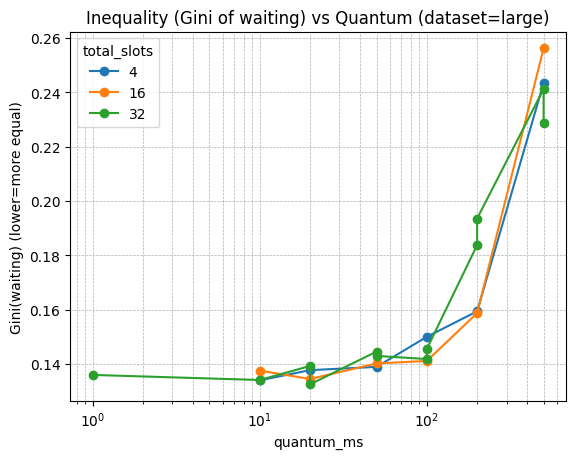

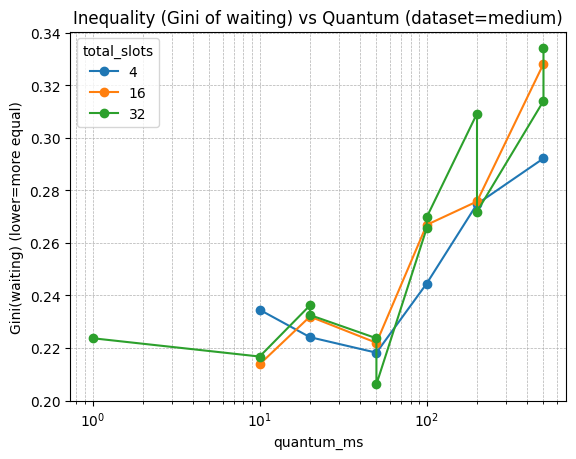

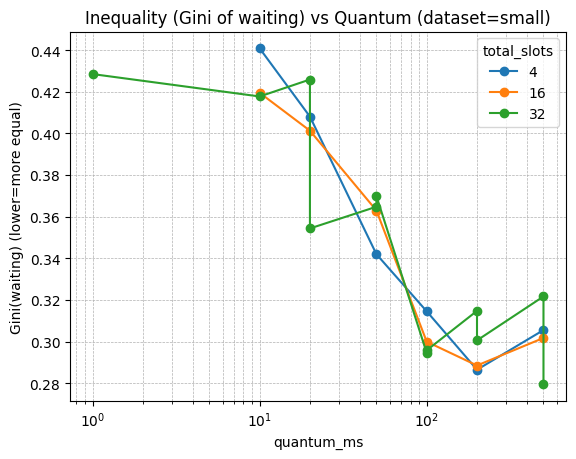

In [27]:
# -------------------------
# 9) F) Gini(waiting) vs quantum (per dataset)
# -------------------------
if "fairness.waiting_gini" in df.columns and df["fairness.waiting_gini"].notna().any():
    for ds in _dataset_values(df):
        sub = df[df["dataset"] == ds].copy()
        _plot_lines_by_group(
            sub,
            x="quantum_ms",
            y="fairness.waiting_gini",
            group="total_slots",
            title=f"Inequality (Gini of waiting) vs Quantum (dataset={ds})",
            xlabel="quantum_ms",
            ylabel="Gini(waiting) (lower=more equal)",
            logx=True,
            logy=False,
        )
else:
    print("Missing fairness.waiting_gini; skip waiting Gini plots.")


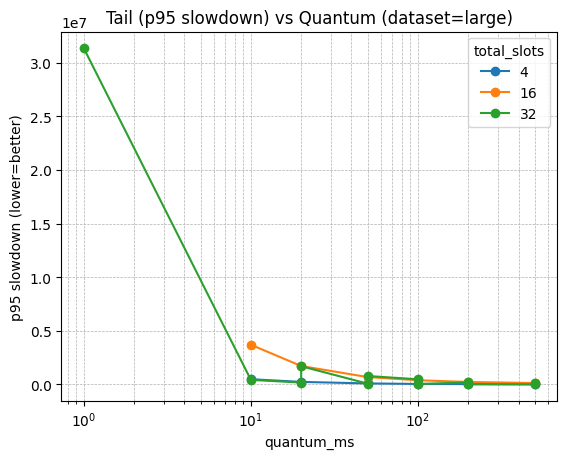

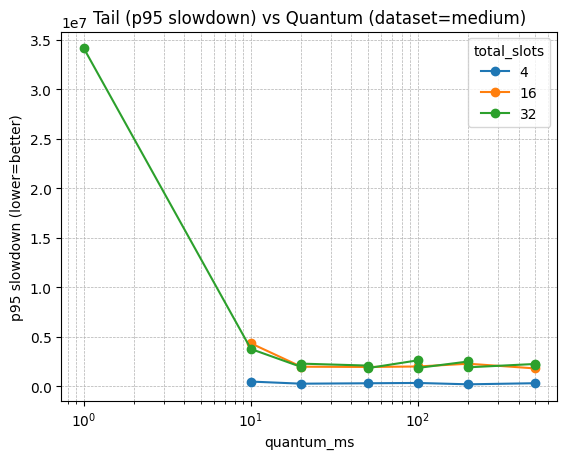

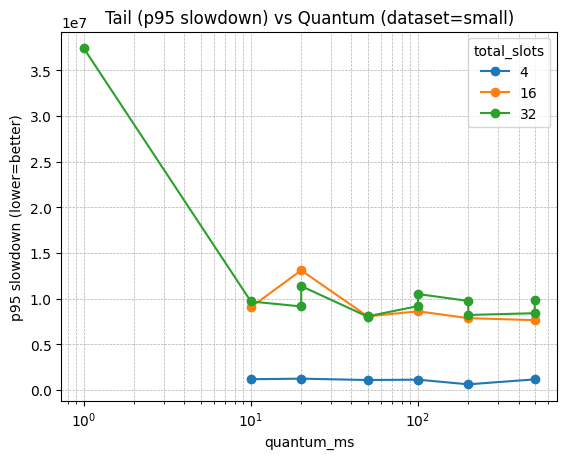

In [28]:
# -------------------------
# 10) G) Tail fairness vs quantum: slowdown_p95 (per dataset)
# -------------------------
if "fairness.slowdown_p95" in df.columns and df["fairness.slowdown_p95"].notna().any():
    for ds in _dataset_values(df):
        sub = df[df["dataset"] == ds].copy()
        _plot_lines_by_group(
            sub,
            x="quantum_ms",
            y="fairness.slowdown_p95",
            group="total_slots",
            title=f"Tail (p95 slowdown) vs Quantum (dataset={ds})",
            xlabel="quantum_ms",
            ylabel="p95 slowdown (lower=better)",
            logx=True,
            logy=False,
        )
else:
    print("Missing fairness.slowdown_p95; skip tail slowdown plots.")


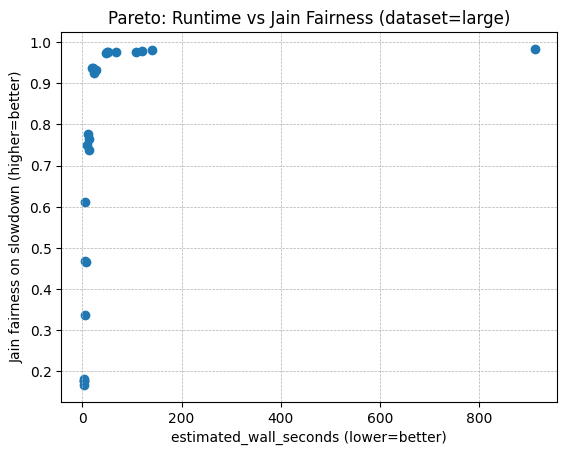

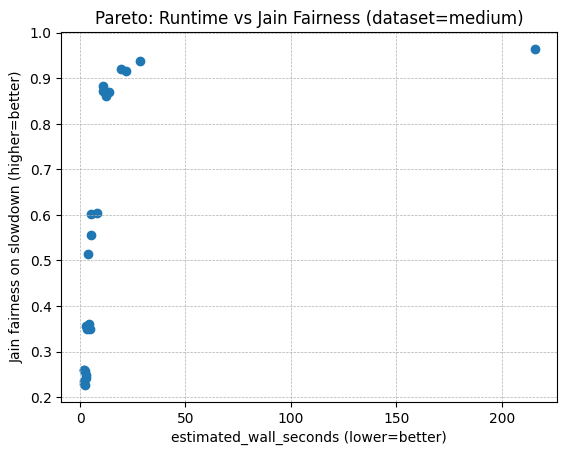

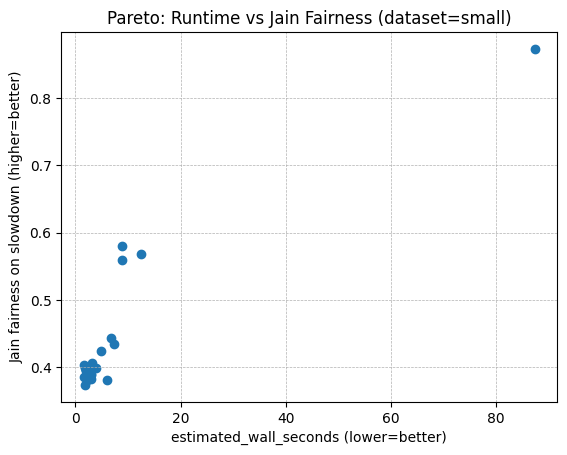

In [29]:
# -------------------------
# 11) H) Pareto: time vs fairness (Jain)
# One plot per dataset.
# -------------------------
if "fairness.slowdown_jain" in df.columns and df["fairness.slowdown_jain"].notna().any():
    for ds in _dataset_values(df):
        sub = df[df["dataset"] == ds].copy()
        # Optional: reduce clutter by filtering to a few quanta
        _plot_scatter(
            sub,
            x="total_time_to_run.estimated_wall_seconds",
            y="fairness.slowdown_jain",
            label_col=None,
            title=f"Pareto: Runtime vs Jain Fairness (dataset={ds})",
            xlabel="estimated_wall_seconds (lower=better)",
            ylabel="Jain fairness on slowdown (higher=better)",
            logx=False,
            logy=False,
        )
else:
    print("Missing fairness.slowdown_jain; skip Pareto plot.")


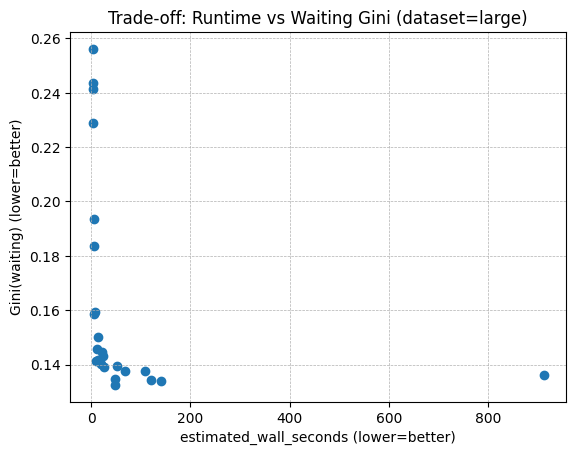

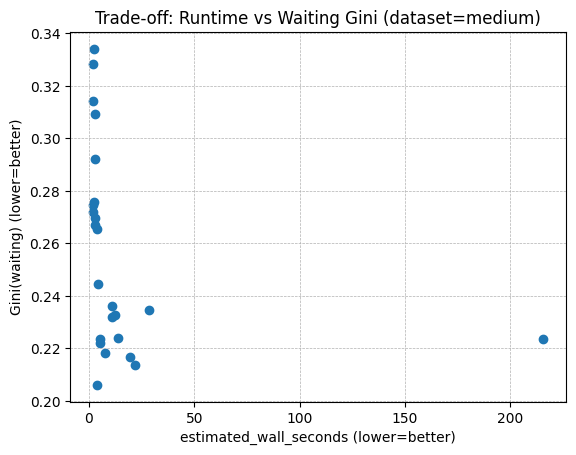

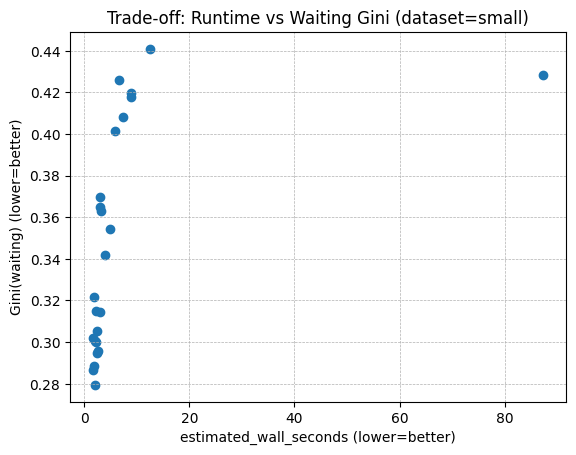

In [30]:
# -------------------------
# 12) I) Pareto: time vs inequality (waiting_gini)
# -------------------------
if "fairness.waiting_gini" in df.columns and df["fairness.waiting_gini"].notna().any():
    for ds in _dataset_values(df):
        sub = df[df["dataset"] == ds].copy()
        _plot_scatter(
            sub,
            x="total_time_to_run.estimated_wall_seconds",
            y="fairness.waiting_gini",
            label_col=None,
            title=f"Trade-off: Runtime vs Waiting Gini (dataset={ds})",
            xlabel="estimated_wall_seconds (lower=better)",
            ylabel="Gini(waiting) (lower=better)",
            logx=False,
            logy=False,
        )
else:
    print("Missing fairness.waiting_gini; skip runtime-vs-gini plot.")


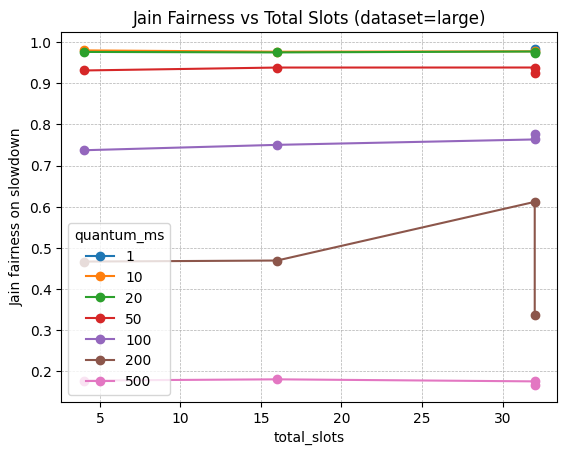

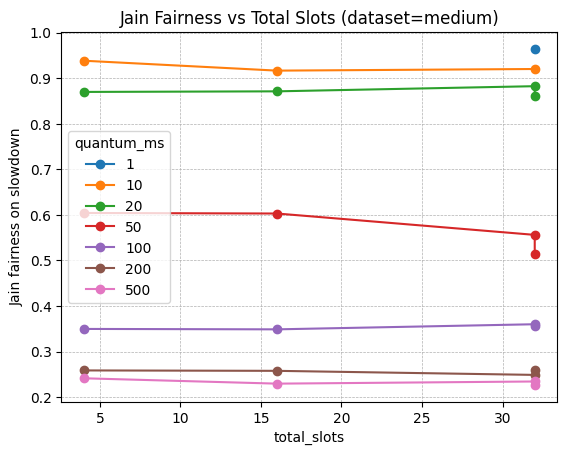

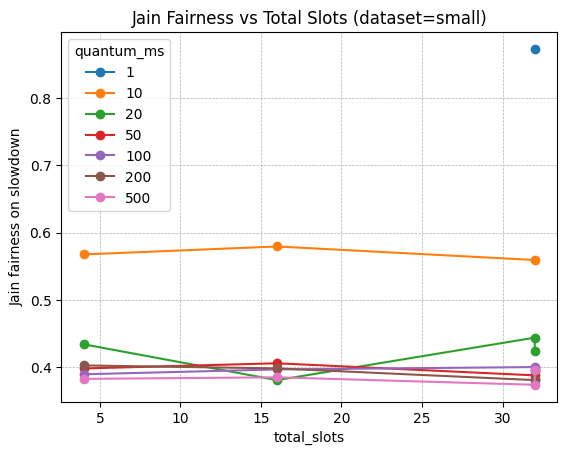

In [31]:
# -------------------------
# 13) J) Fairness vs total slots (does more hardware improve fairness?)
# Jain vs total_slots, line per quantum
# -------------------------
if "fairness.slowdown_jain" in df.columns and df["fairness.slowdown_jain"].notna().any():
    for ds in _dataset_values(df):
        sub = df[df["dataset"] == ds].copy()
        _plot_lines_by_group(
            sub,
            x="total_slots",
            y="fairness.slowdown_jain",
            group="quantum_ms",
            title=f"Jain Fairness vs Total Slots (dataset={ds})",
            xlabel="total_slots",
            ylabel="Jain fairness on slowdown",
            logx=False,
            logy=False,
        )


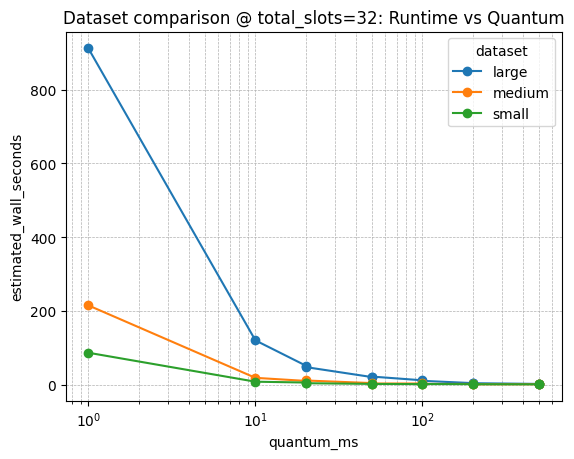

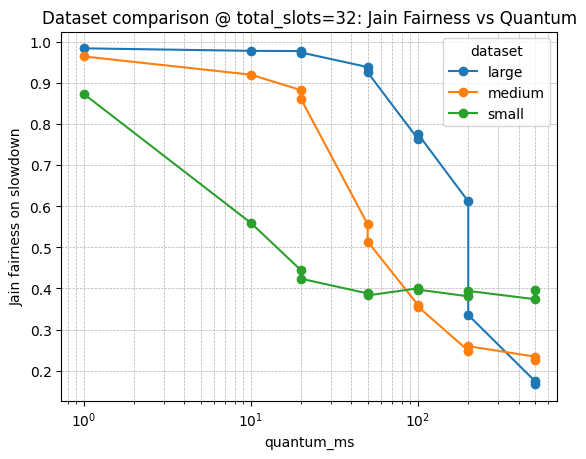

In [ ]:
# -------------------------
# 14) K) Dataset sensitivity at a fixed cluster size
# -------------------------
common_slots = df["total_slots"].value_counts().idxmax()
fixed = df[df["total_slots"] == common_slots].copy()

_plot_lines_by_group(
    fixed,
    x="quantum_ms",
    y="total_time_to_run.estimated_wall_seconds",
    group="dataset",
    title=f"Dataset comparison @ total_slots={common_slots}: Runtime vs Quantum",
    xlabel="quantum_ms",
    ylabel="estimated_wall_seconds",
    logx=True,
    logy=False,
)

if "fairness.slowdown_jain" in fixed.columns and fixed["fairness.slowdown_jain"].notna().any():
    _plot_lines_by_group(
        fixed,
        x="quantum_ms",
        y="fairness.slowdown_jain",
        group="dataset",
        title=f"Dataset comparison @ total_slots={common_slots}: Jain Fairness vs Quantum",
        xlabel="quantum_ms",
        ylabel="Jain fairness on slowdown",
        logx=True,
        logy=False,
    )


In [ ]:
# -------------------------
# 15) L) Avg slices per job vs quantum 
# -------------------------
candidate_cols = ["fairness.avg_slices_per_job", "avg_slices_per_job"]
slices_col = next((c for c in candidate_cols if c in df.columns and df[c].notna().any()), None)

if slices_col:
    for ds in _dataset_values(df):
        sub = df[df["dataset"] == ds].copy()
        _plot_lines_by_group(
            sub,
            x="quantum_ms",
            y=slices_col,
            group="total_slots",
            title=f"Avg slices/job vs Quantum (dataset={ds})",
            xlabel="quantum_ms",
            ylabel=slices_col,
            logx=True,
            logy=False,
        )
else:
    print("No avg_slices_per_job found in JSON. If you want this plot, add it to the JSON exporter.")


No avg_slices_per_job found in JSON. If you want this plot, add it to the JSON exporter.


In [34]:
# -------------------------
# 16) M) Runtime vs avg slices per job (if available)
# -------------------------
if slices_col:
    for ds in _dataset_values(df):
        sub = df[df["dataset"] == ds].copy()
        _plot_scatter(
            sub,
            x=slices_col,
            y="total_time_to_run.estimated_wall_seconds",
            label_col=None,
            title=f"Runtime vs Avg slices/job (dataset={ds})",
            xlabel=slices_col,
            ylabel="estimated_wall_seconds",
            logx=False,
            logy=False,
        )


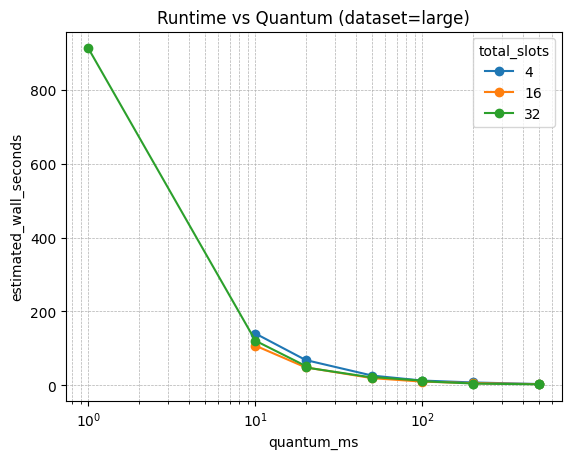

In [ ]:
# -------------------------
# 17) Optional: Save all plots to PNGs
ds = _dataset_values(df)[0] if _dataset_values(df) else None
if ds:
    sub = df[df["dataset"] == ds].copy()
    plt.figure()
    for g, s in sub.groupby("total_slots"):
        s = s.dropna(subset=["quantum_ms","total_time_to_run.estimated_wall_seconds"]).sort_values("quantum_ms")
        if len(s) == 0: 
            continue
        plt.plot(s["quantum_ms"], s["total_time_to_run.estimated_wall_seconds"], marker="o", label=str(g))
    plt.title(f"Runtime vs Quantum (dataset={ds})")
    plt.xlabel("quantum_ms")
    plt.ylabel("estimated_wall_seconds")
    plt.xscale("log")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend(title="total_slots", loc="best")
    Path("plots").mkdir(exist_ok=True)
    plt.savefig(Path("plots") / f"runtime_vs_quantum_{ds}.png", dpi=150, bbox_inches="tight")
    plt.show()
